In [167]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
from scipy import stats
from scipy.special import boxcox, inv_boxcox
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing
import matplotlib 
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

matplotlib.style.use('ggplot')
warnings.filterwarnings("ignore")

### Analysis

**Data Set Information:**

A detailed description of the dataset can be found in the Dataset section of the following paper:

Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone". BMC Medical Informatics and Decision Making 20, 16 (2020).

**Thirteen (13) clinical features:**

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- [target] death event: if the patient deceased during the follow-up period (boolean)

**Dataset nominal categorical features:**
- anemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT(target)
- don't need to use label encoding because categories are int

In [19]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv")
display(df.describe().T)
display(df.dtypes)
display(df.isnull().sum())

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Observations:
- Noticable statistical deviations between different features
- Categorical features like sex, smoking and others should be encoded

In [25]:
# Shows the Distribution of Heat Diseases with respect to age
fig=px.histogram(df, 
                 x="age",
                 color="DEATH_EVENT",
                 hover_data=df.columns,
                 title="Distribution")
fig.show()

In [22]:
px.imshow(df.corr(), title="Correlation Plot (heatmap)")

[]

<Figure size 3000x2000 with 0 Axes>

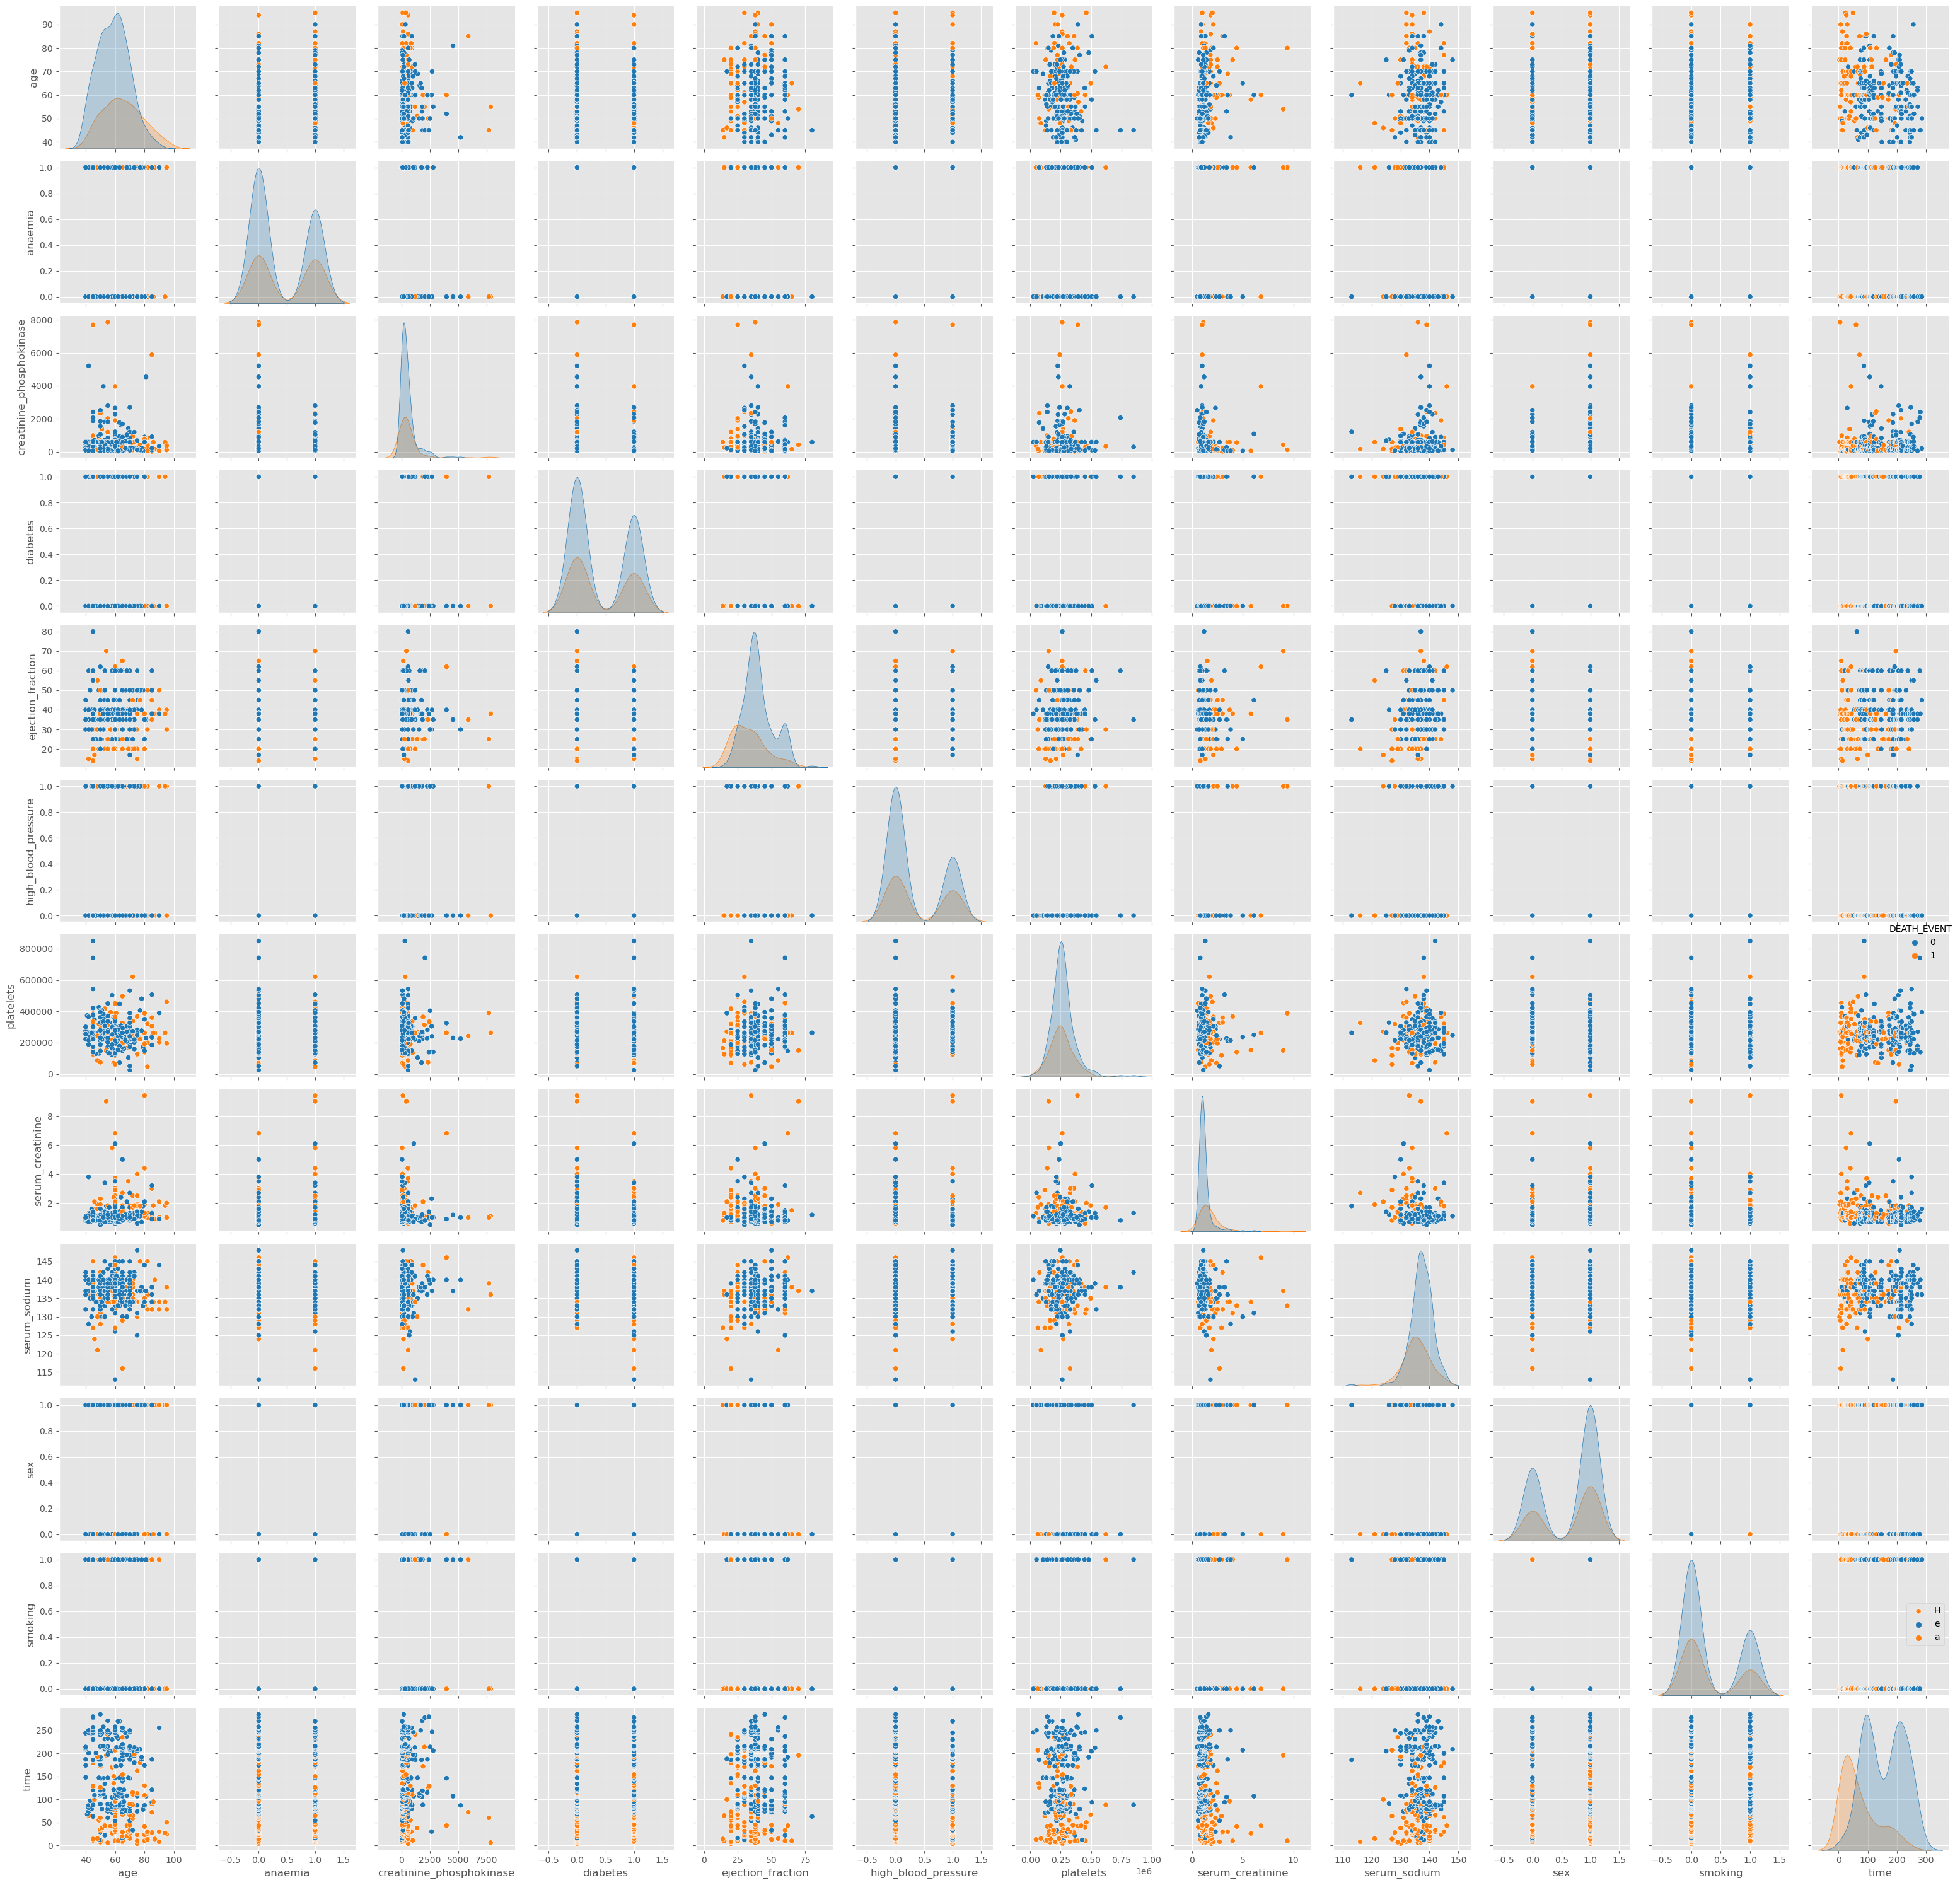

In [33]:
plt.figure(figsize=(30,20))
sns.pairplot(df, hue="DEATH_EVENT", palette="tab10")
plt.tight_layout()
plt.plot()

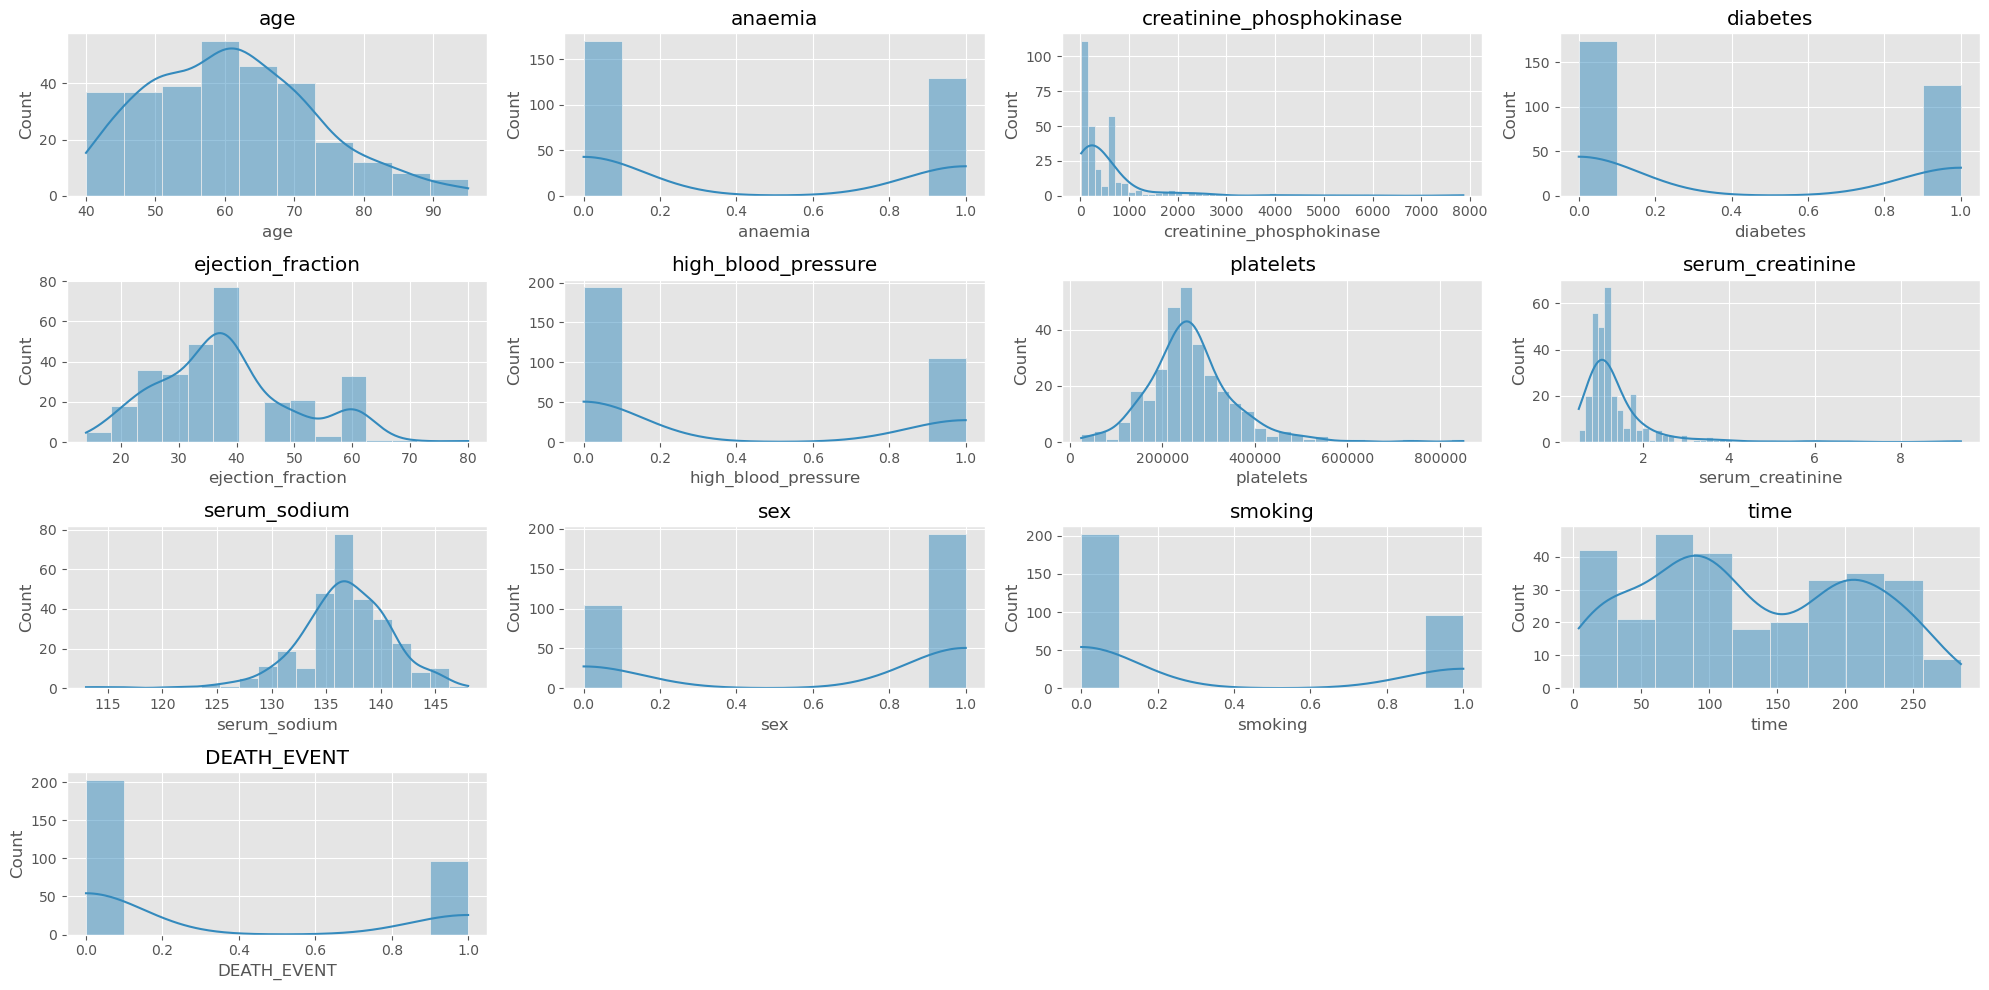

In [48]:
plt.figure(figsize=(20,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,4,i)
    plt.title("{}".format(col))
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

[]

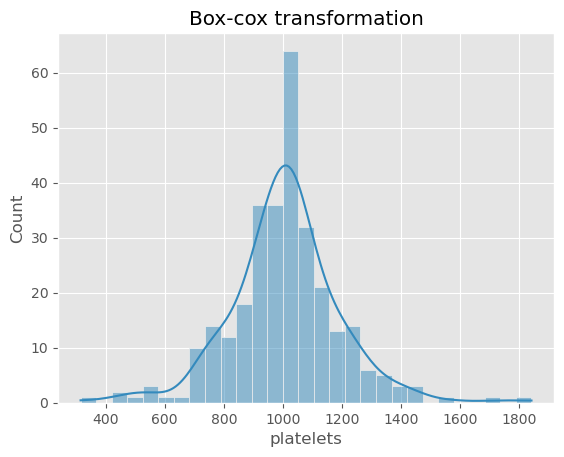

In [97]:
transformed_data = boxcox(df.platelets, 0.5)
# inv_boxcox(data, 0.5)
sns.histplot(transformed_data, kde=True)
plt.title("Box-cox transformation")
plt.plot()

### Modeling

In [100]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

In [205]:
# Make pipelines
categ_col = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
pre_process = ColumnTransformer([
    # ('Log transform', np.log1p()),  # create custom transformer for X
    ('OHE', OneHotEncoder(sparse=True), categ_col),
    ],remainder='drop').fit_transform(df)
categ_names = ['anaemia_n', 'anaemia_y', 
        'diabetes_n', 'diabetes_y', 
        'hbp_n', 'hbp_y', 
        'sex_m', 'sex_f', 
        'smoking_n', 'smoking_y']
pd.DataFrame(pre_process, columns=categ_names)

,anaemia_n,anaemia_y,diabetes_n,diabetes_y,hbp_n,hbp_y,sex_m,sex_f,smoking_n,smoking_y
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
294,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
295,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
296,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
297,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


Concatenate to original df and drop categ_col